In [1]:
from qat.qlmaas import QLMaaSConnection
conn = QLMaaSConnection(hostname="qlm35e.neasqc.eu", check_host=False)

In [2]:
import parameters
from SQA_hyper_tuning_BO import BayesianOptimizer, SQA_solver, Brute_Force_Solver
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [3]:
n_shots, delta_t = parameters.n_shots, parameters.delta_t
n_init, n_iters = parameters.n_init, parameters.n_iters
min_vals, max_vals = parameters.min_vals, parameters.max_vals
bounds = [(min_vals[i], max_vals[i]) for i in range(len(min_vals))]

In [8]:
n_spinss = np.array([5, 10, 15, 20])
n_repeats = 4  # Number of times to repeat the optimization with different seeds

energies = np.zeros((len(n_spinss), n_iters, n_repeats))
betas = np.zeros_like(energies)
annealing_times = np.zeros_like(energies)
gamma_0s = np.zeros_like(energies)
n_trotterss = np.zeros_like(energies)

opt_energy = np.zeros((len(n_spinss), n_repeats))
opt_betas = np.zeros((len(n_spinss), n_repeats))
opt_annealing_times = np.zeros((len(n_spinss), n_repeats))
opt_gamma_0s = np.zeros((len(n_spinss), n_repeats))
opt_n_trotterss = np.zeros((len(n_spinss), n_repeats))

times = np.zeros((len(n_spinss), n_repeats))

bf_energies = np.zeros_like(n_spinss)
bf_times = np.zeros_like(n_spinss)

for i, n_spins in enumerate(n_spinss):
    sqa = SQA_solver(n_spins=n_spins, n_shots=n_shots, delta_t=delta_t)
    # Generate a random Ising problem (same for all runs)
    J, h = sqa.generate_random_problems(n_examples=1, seed=1)
    print(f"Running BO for n_spins = {n_spins}...")
    for j in range(n_repeats):
        print(f"Repetition {j+1}/{n_repeats}")
        start = time.time()
        bo = BayesianOptimizer(sqa=sqa, bounds=bounds, n_init=n_init, seed=j+1)
        X_opt, Y_opt, history = bo.optimize(n_iters=n_iters)
        end = time.time()

        best_idx = np.argmin(Y_opt)
        opt_energy[i,j] = Y_opt[best_idx][0]
        opt_betas[i,j] = X_opt[best_idx][0]
        opt_annealing_times[i,j] = X_opt[best_idx][1]
        opt_gamma_0s[i,j] = X_opt[best_idx][2]    
        opt_n_trotterss[i,j] = int(X_opt[best_idx][3])

        energies[i,:,j] = np.array([t[1] for t in history])
        betas[i,:,j] = np.array([t[0][0] for t in history])
        annealing_times[i,:,j] = np.array([t[0][1] for t in history])
        gamma_0s[i,:,j] = np.array([t[0][2] for t in history])
        n_trotterss[i,:,j] = np.array([t[0][3] for t in history])
        times[i,j] = end -start

    bf_start = time.time()
    bf_solver = Brute_Force_Solver(J, h)
    exact_gs_energy, _ = bf_solver.brute_force_solve()
    bf_end = time.time()
    bf_energies[i] = exact_gs_energy
    bf_times[i] = bf_end - bf_start
    
print("\nSimulation completed. Taking averages and standard deviations...")
avg_energies = np.mean(energies, axis=2)
avg_betas = np.mean(betas, axis=2)
avg_annealing_times = np.mean(annealing_times, axis=2)
avg_gamma_0s = np.mean(gamma_0s, axis=2)
avg_n_trotterss = np.mean(n_trotterss, axis=2)

std_energies = np.std(energies, axis=2)
std_betas = np.std(betas, axis=2)
std_annealing_times = np.std(annealing_times, axis=2)
std_gamma_0s = np.std(gamma_0s, axis=2)
std_n_trotterss = np.std(n_trotterss, axis=2)


Running BO for n_spins = 5...
Repetition 1/4
Submitted a new batch: SJob44172
Submitted a new batch: SJob44173
Submitted a new batch: SJob44174
Submitted a new batch: SJob44175
Submitted a new batch: SJob44176
Submitted a new batch: SJob44177
Submitted a new batch: SJob44178
Submitted a new batch: SJob44179
Submitted a new batch: SJob44180
Submitted a new batch: SJob44181
Submitted a new batch: SJob44182
Submitted a new batch: SJob44183
Submitted a new batch: SJob44184
Submitted a new batch: SJob44185
Submitted a new batch: SJob44186
Submitted a new batch: SJob44187
Submitted a new batch: SJob44188
Submitted a new batch: SJob44189
Submitted a new batch: SJob44190
Submitted a new batch: SJob44191
Submitted a new batch: SJob44192
Submitted a new batch: SJob44193
Submitted a new batch: SJob44194
Submitted a new batch: SJob44195
Submitted a new batch: SJob44196
Submitted a new batch: SJob44197
Submitted a new batch: SJob44198
Submitted a new batch: SJob44199
Submitted a new batch: SJob4420

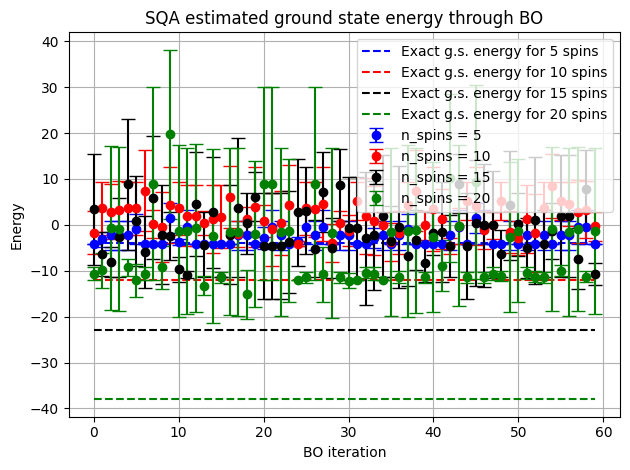

In [9]:
# Plot energies
colors = ['blue', 'red', 'black', 'green', 'orange']
plt.figure()
for i, n_spins in enumerate(n_spinss):
    plt.errorbar(range(n_iters), avg_energies[i,:], std_energies[i,:], fmt='o', color = colors[i], capsize=5, label=f'n_spins = {n_spins}')
    plt.plot(range(n_iters), np.array([bf_energies[i]]*n_iters), '--', color = colors[i], label=f'Exact g.s. energy for {n_spins} spins')
plt.xlabel('BO iteration')
plt.ylabel('Energy')
plt.title('SQA estimated ground state energy through BO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

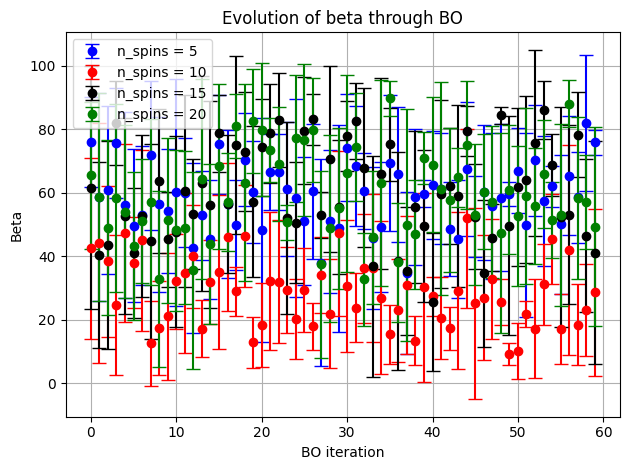

In [10]:
# Plot betas
colors = ['blue', 'red', 'black', 'green', 'orange']
plt.figure()
for i, n_spins in enumerate(n_spinss):
    plt.errorbar(range(n_iters), avg_betas[i,:], std_betas[i,:], fmt='o', color = colors[i], capsize=5, label=f'n_spins = {n_spins}')
plt.xlabel('BO iteration')
plt.ylabel('Beta')
plt.title('Evolution of beta through BO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

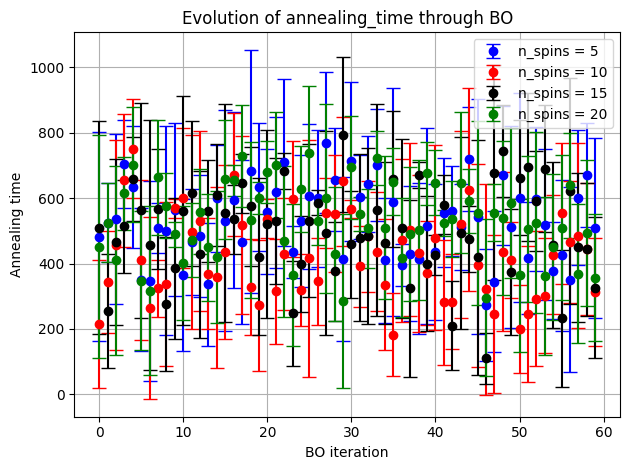

In [11]:
# Plot annealing_times
colors = ['blue', 'red', 'black', 'green', 'orange']
plt.figure()
for i, n_spins in enumerate(n_spinss):
    plt.errorbar(range(n_iters), avg_annealing_times[i,:], std_annealing_times[i,:], fmt='o', color = colors[i], capsize=5, label=f'n_spins = {n_spins}')
plt.xlabel('BO iteration')
plt.ylabel('Annealing time')
plt.title('Evolution of annealing_time through BO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

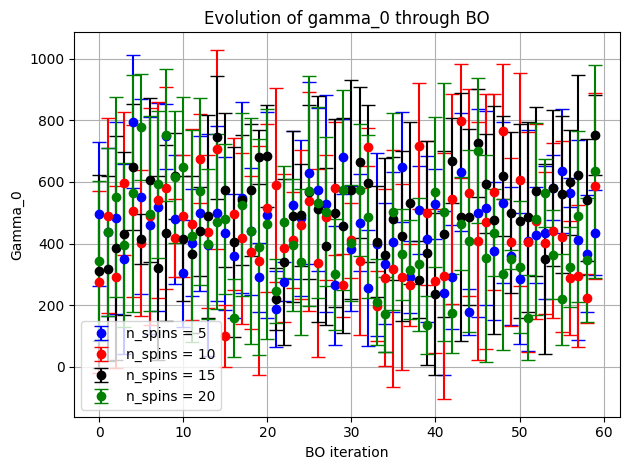

In [12]:
# Plot gamma_0s
colors = ['blue', 'red', 'black', 'green', 'orange']
plt.figure()
for i, n_spins in enumerate(n_spinss):
    plt.errorbar(range(n_iters), avg_gamma_0s[i,:], std_gamma_0s[i,:], fmt='o', color = colors[i], capsize=5, label=f'n_spins = {n_spins}')
plt.xlabel('BO iteration')
plt.ylabel('Gamma_0')
plt.title('Evolution of gamma_0 through BO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

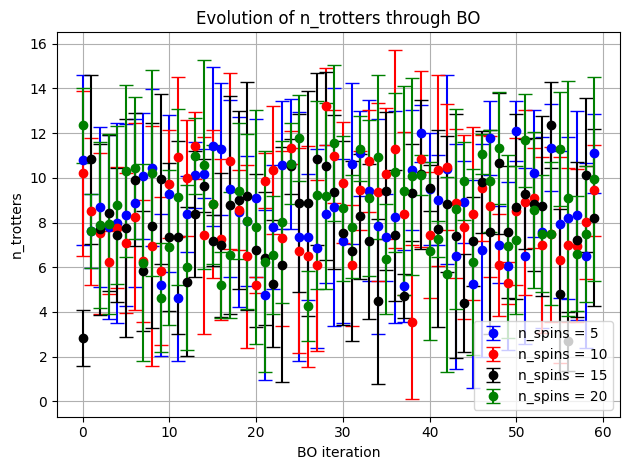

In [13]:
# Plot n_trotterss
colors = ['blue', 'red', 'black', 'green', 'orange']
plt.figure()
for i, n_spins in enumerate(n_spinss):
    plt.errorbar(range(n_iters), avg_n_trotterss[i,:], std_n_trotterss[i,:], fmt='o', color = colors[i], capsize=5, label=f'n_spins = {n_spins}')
plt.xlabel('BO iteration')
plt.ylabel('n_trotters')
plt.title('Evolution of n_trotters through BO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Select first repetition instead of average

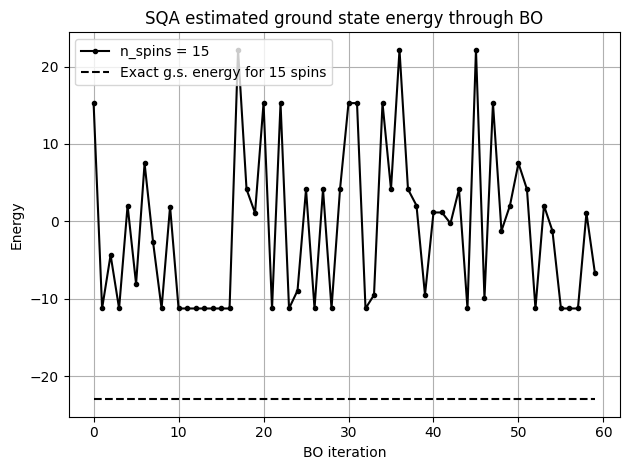

In [47]:
# Plot energies
colors = ['blue', 'red', 'black', 'green', 'orange']
n_spinss = [5, 10, 15, 20]
n_spins_represented = 15
plt.figure()
for i, n_spins in enumerate(n_spinss):
    if n_spins == n_spins_represented:
        plt.plot(range(n_iters), energies[i,:,3],'.-', color = colors[i], label=f'n_spins = {n_spins}')
        plt.plot(range(n_iters), np.array([bf_energies[i]]*n_iters), '--', color = colors[i], label=f'Exact g.s. energy for {n_spins} spins')
        break
plt.xlabel('BO iteration')
plt.ylabel('Energy')
plt.title('SQA estimated ground state energy through BO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

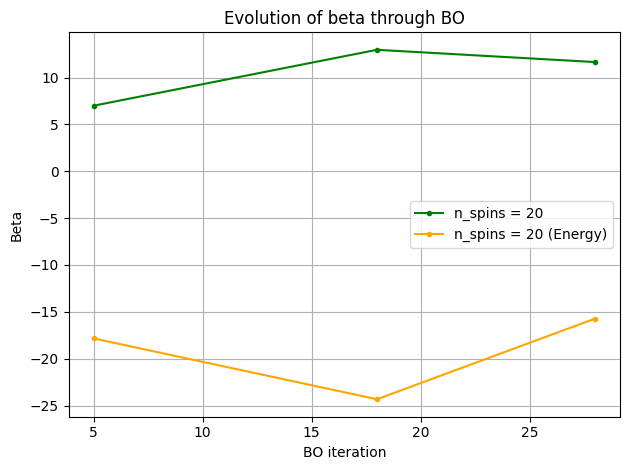

Correlation of energy and beta =  -0.001655753174447939
-38


In [164]:
# Plot betas
colors = ['blue', 'red', 'black', 'green', 'orange']
n_spins_represented = 20
plt.figure()
for i, n_spins in enumerate(n_spinss):
    if n_spins == n_spins_represented:
        energies_opt = energies[i,:,0]
        indices = np.where(energies_opt < -13.5)[0]
        plt.plot(indices, betas[i,indices,0], '.-', color = colors[i], label=f'n_spins = {n_spins}')
        plt.plot(indices, energies_opt[indices],'.-', color = 'orange', label=f'n_spins = {n_spins} (Energy)')
        break
plt.xlabel('BO iteration')
plt.ylabel('Beta')
plt.title('Evolution of beta through BO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

corr_energy_beta = np.corrcoef(betas[3,:,3], energies[3,:,3])[0, 1]
print("Correlation of energy and beta = ", corr_energy_beta)
print(bf_energies[3])

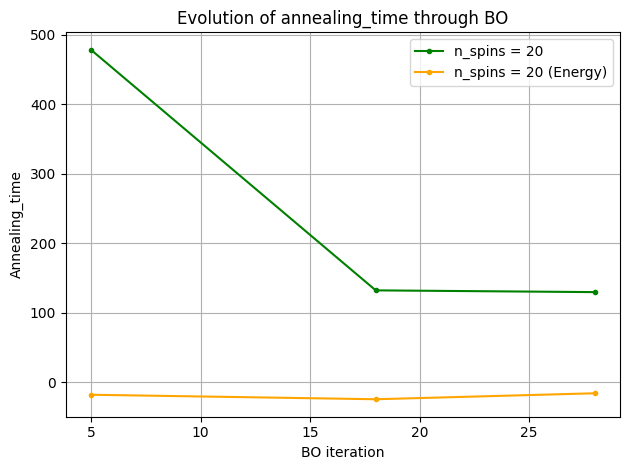

Correlation of energy and beta =  0.13791568257195266


In [166]:
# Plot annealing_times
colors = ['blue', 'red', 'black', 'green', 'orange']
n_spins_represented = 20
plt.figure()
for i, n_spins in enumerate(n_spinss):
    if n_spins == n_spins_represented:
        energies_opt = energies[i,:,0]
        indices = np.where(energies_opt < -13.5)[0]
        plt.plot(indices, annealing_times[i,indices,0], '.-', color = colors[i], label=f'n_spins = {n_spins}')
        plt.plot(indices, energies_opt[indices],'.-', color = 'orange', label=f'n_spins = {n_spins} (Energy)')
        break
plt.xlabel('BO iteration')
plt.ylabel('Annealing_time')
plt.title('Evolution of annealing_time through BO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

corr_energy_beta = np.corrcoef(annealing_times[3,:,2], energies[3,:,2])[0, 1]
print("Correlation of energy and beta = ", corr_energy_beta)

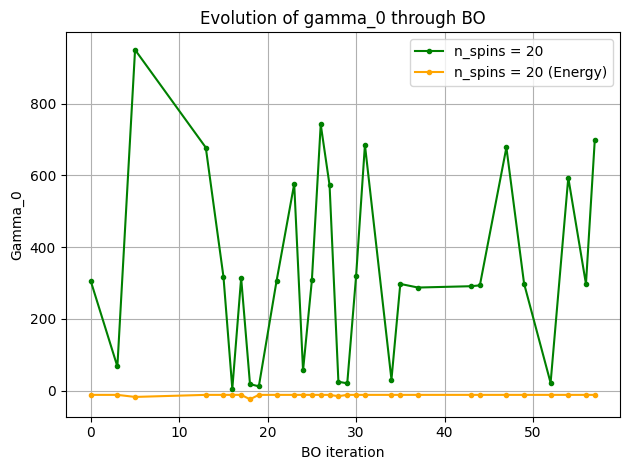

Correlation of energy and beta =  -0.014434865636966538


In [172]:
# Plot gamma_0s
colors = ['blue', 'red', 'black', 'green', 'orange']
n_spins_represented = 20
plt.figure()
for i, n_spins in enumerate(n_spinss):
    if n_spins_represented == n_spins:
        energies_opt = energies[i,:,0]
        indices = np.where(energies_opt < -12)[0]
        plt.plot(indices, gamma_0s[i,indices,0], '.-', color = colors[i], label=f'n_spins = {n_spins}')
        plt.plot(indices, energies_opt[indices],'.-', color = 'orange', label=f'n_spins = {n_spins} (Energy)')
        break
plt.xlabel('BO iteration')
plt.ylabel('Gamma_0')
plt.title('Evolution of gamma_0 through BO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

corr_energy_beta = np.corrcoef(gamma_0s[3,:,2], energies[3,:,2])[0, 1]
print("Correlation of energy and beta = ", corr_energy_beta)

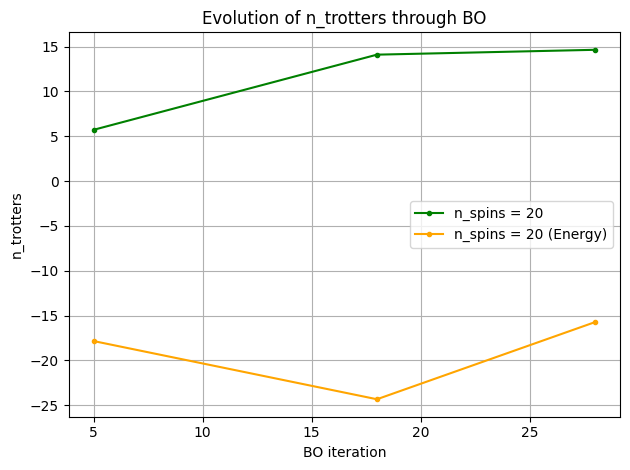

Correlation of energy and beta =  -0.7493964649342071
[ 5 18 28]


In [168]:
# Plot n_trotterss
colors = ['blue', 'red', 'black', 'green', 'orange']
n_spins_represented = 20
plt.figure()
for i, n_spins in enumerate(n_spinss):
    if n_spins == n_spins_represented:
        energies_opt = energies[i,:,0]
        indices = np.where(energies_opt < -13.5)[0]
        
        plt.plot(indices, n_trotterss[i,indices,0], '.-', color = colors[i], label=f'n_spins = {n_spins}')
        plt.plot(indices, energies_opt[indices],'.-', color = 'orange', label=f'n_spins = {n_spins} (Energy)')
        break
plt.xlabel('BO iteration')
plt.ylabel('n_trotters')
plt.title('Evolution of n_trotters through BO')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

corr_energy_n_totters = np.corrcoef(n_trotterss[3,:,0], energies[3,:,0])[0, 1]
print("Correlation of energy and beta = ", corr_energy_n_totters)
print(indices)